In [1]:
import torch
import numpy as np
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import CNNEmbedding, FCEmbedding
from sbi.inference import NPE, simulate_for_sbi
from sbi.utils import BoxUniform
from sbi import analysis

from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq
from scipy.stats import skew, kurtosis

from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

import matplotlib.pyplot as plt

In [2]:
ts, dt = (10.0, 0.1)
def mass_spring_damper_simulator(theta):
    m, k, b = theta
    steps = int(ts/dt)
    x0 = torch.normal(mean=10.0, std=3.0, size=(1,))
    v0 = torch.normal(mean=3.0, std=1.0, size=(1,))
    x, v = float(x0), float(v0)  # Initial conditions
    force = np.cos(np.arange(steps) * dt * 10)
    trajectory = []

    for f in force:
        x_new = x + dt * v
        v_new = v + dt * (-k * x / m - b * v / m + f / m)
        x, v = x_new, v_new
        trajectory.append([x, v])
    # trajectory = torch.tensor(trajectory)
    # noise_std = 0.1 
    # trajectory += torch.randn_like(trajectory) * noise_std
    # return trajectory.clone().detach()
    return torch.tensor(trajectory)

In [3]:
def mass_spring_damper_fixed_simulator(theta):
    m, k, b = theta
    steps = int(ts/dt)
    x, v = 0, 5  # Initial conditions
    force = np.cos(np.arange(steps) * dt * 10)
    trajectory = []

    for f in force:
        x_new = x + dt * v
        v_new = v + dt * (-k * x / m - b * v / m + f / m)
        x, v = x_new, v_new
        trajectory.append([x, v])

    return torch.tensor(trajectory)

In [4]:
def compute_summary_statistics(trajectory, dt=0.1):
    """
    Compute summary statistics for a mass-spring-damper trajectory.
    
    Parameters:
        trajectory (torch.Tensor): Tensor of shape (timesteps, 2) where:
                                   trajectory[:, 0] -> Position (x)
                                   trajectory[:, 1] -> Velocity (v)
        dt (float): Time step (default = 0.1s)

    Returns:
        torch.Tensor: Summary statistics vector
    """
    trajectory = trajectory.numpy()  # Convert to NumPy
    x = trajectory[:, 0]  # Position
    v = trajectory[:, 1]  # Velocity
    t = np.arange(len(x)) * dt  # Time vector

    # Time-Domain Features
    x_max = np.max(x)  # Max position
    v_max = np.max(v)  # Max velocity
    x_var = np.var(x)  # Position variance
    v_var = np.var(v)  # Velocity variance
    x_skew = skew(x)   # Skewness
    v_skew = skew(v)
    x_kurt = kurtosis(x)  # Kurtosis
    v_kurt = kurtosis(v)

    # Find peaks in position signal
    peaks, _ = find_peaks(x)
    if len(peaks) > 1:
        time_to_first_peak = t[peaks[0]]
        peak_decay = np.log(np.abs(x[peaks[:-1]] / x[peaks[1:]])).mean()  # Log decrement
    else:
        time_to_first_peak = 0
        peak_decay = 0

    # Zero-Crossing Rate
    zero_crossings = np.where(np.diff(np.sign(x)))[0]
    zero_crossing_rate = len(zero_crossings) / len(x)

    # Energy Dissipated per Cycle
    energy = np.sum(x**2 + v**2) * dt  # Approximate energy integral

    # Frequency-Domain Features
    fft_x = np.abs(fft(x))  # Magnitude of FFT
    freqs = fftfreq(len(x), d=dt)  # Corresponding frequencies
    peak_freq_idx = np.argmax(fft_x[1:]) + 1  # Ignore DC component
    dominant_frequency = freqs[peak_freq_idx]
    spectral_power = fft_x[peak_freq_idx]

    # Combine all features into a single vector
    summary_statistics = np.array([
        x_max, v_max, x_var, v_var, x_skew, v_skew, x_kurt, v_kurt,
        time_to_first_peak, peak_decay, zero_crossing_rate, energy,
        dominant_frequency, spectral_power
    ])
    
    return torch.tensor(summary_statistics, dtype=torch.float32)

In [5]:
true_parameter = torch.tensor([10, 5.0, 2.0])
x_observed = mass_spring_damper_fixed_simulator(true_parameter)

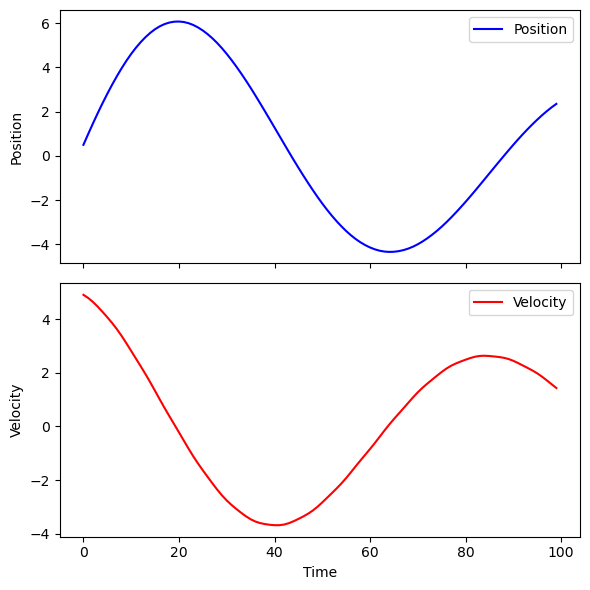

In [6]:
t = torch.arange(len(x_observed))

fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
# Plot first column
axes[0].plot(t, x_observed[:, 0], label="Position", color="b")
axes[0].set_ylabel("Position")
axes[0].legend()

# Plot second column
axes[1].plot(t, x_observed[:, 1], label="Velocity", color="r")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Velocity")
axes[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

In [7]:
# dim = int(ts/dt) * 2
# embedding_net = CNNEmbedding(
#     input_shape=(dim, ), 
#     output_dim=16,
#     # out_channels_per_layer=[64, 128, 256],
#     # num_conv_layers=3,
#     # num_linear_layers=3,
#     # num_linear_units=200,
# )

embedding_net = FCEmbedding(
    input_dim=14,
    num_hiddens=64
)

In [8]:
prior = BoxUniform(low=torch.tensor([5.0, 2.0, 0.5]), 
                   high=torch.tensor([15.0, 8.0, 5.0]))

prior, num_parameters, prior_returns_numpy = process_prior(prior)

In [9]:
simulator_wrapper = process_simulator(mass_spring_damper_fixed_simulator, prior, prior_returns_numpy)
check_sbi_inputs(simulator_wrapper, prior)

In [10]:
neural_posterior = posterior_nn(model='maf', embedding_net=embedding_net)

In [11]:
# inference = NPE(prior=prior, density_estimator=neural_posterior)
inference = NPE(prior=prior)

In [12]:
num_simulations = 1000

In [ ]:
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=num_simulations)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
summary_stats_x = torch.stack([compute_summary_statistics(xi) for xi in x])

In [ ]:
summary_stats_x[0]

tensor([ 6.5562e+00,  4.9613e+00,  1.7568e+01,  9.9293e+00, -1.3163e-01,
        -2.4970e-01, -1.3899e+00, -1.4576e+00,  0.0000e+00,  0.0000e+00,
         2.0000e-02,  2.7952e+02,  1.0000e-01,  2.8695e+02])

In [ ]:
# Flatten the input tensor x
density_estimator = inference.append_simulations(theta, summary_stats_x).train()

 Neural network successfully converged after 305 epochs.

In [ ]:
posterior = inference.build_posterior(density_estimator)

In [ ]:
import pickle
with open(f"./models/my_posterior_{num_simulations}.pkl", "wb") as handle:
    pickle.dump(posterior, handle)

In [ ]:
samples = posterior.sample((5000,), x=compute_summary_statistics(x_observed))

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

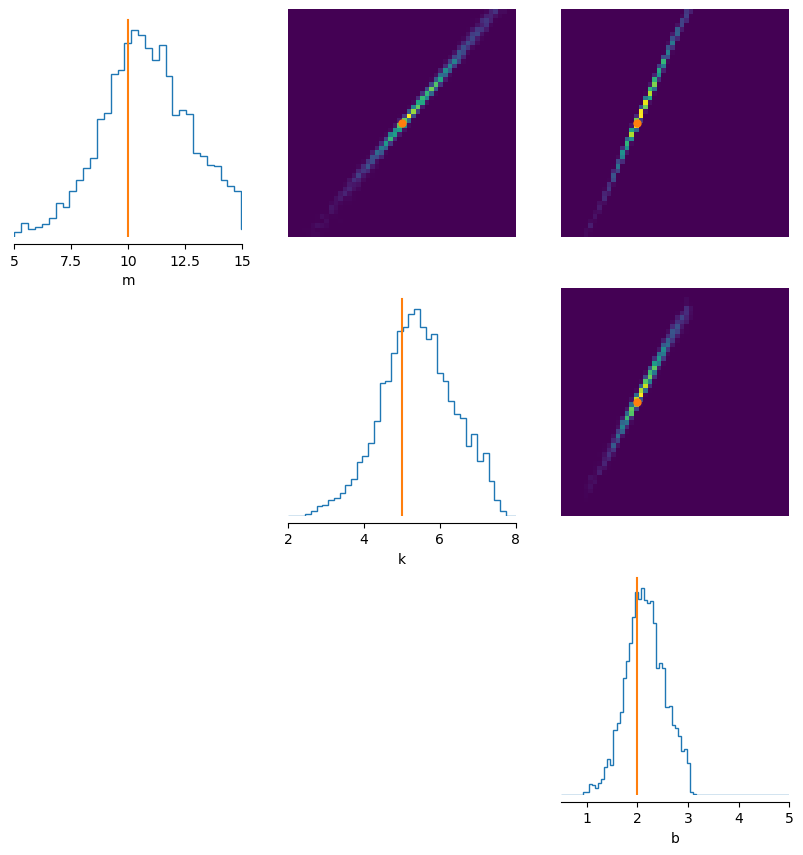

In [ ]:
fig, ax = analysis.pairplot(
    samples,
    points=true_parameter.unsqueeze(0),
    labels=["m", "k", "b"],
    limits=[[5, 15], [2.0, 8.0], [0.5, 5.0]]
)

In [ ]:
# Draw a sample from the posterior and convert to numpy for plotting.
posterior_sample = posterior.sample((1,), x=compute_summary_statistics(x_observed)).numpy()
posterior_min = np.array([[6.5,   2,  0.5]])
posterior_max = np.array([[8.5,   4,  2.5]])
x_min = mass_spring_damper_fixed_simulator(posterior_min.squeeze())
x_max = mass_spring_damper_fixed_simulator(posterior_max.squeeze())
x_posterior = mass_spring_damper_fixed_simulator(posterior_sample.squeeze())
print(posterior_sample)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

[[12.675342   6.3668094  2.537713 ]]


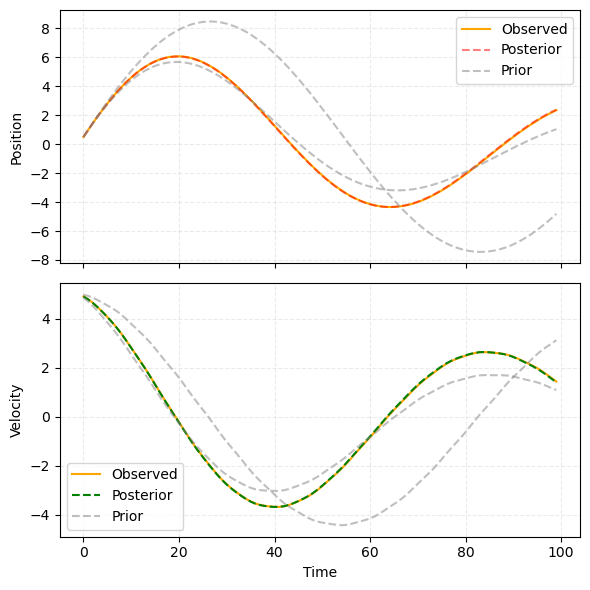

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
# Plot first column
axes[0].plot(t, x_observed[:, 0], label="Observed",color="orange")
axes[0].plot(t, x_posterior[:, 0], label="Posterior", linestyle='--' ,color="red", alpha=0.5)
axes[0].plot(t, x_min[:, 0], label="Prior", linestyle='--' ,color="grey", alpha=0.5)
axes[0].plot(t, x_max[:, 0], linestyle='--' ,color="grey", alpha=0.5)
axes[0].set_ylabel("Position")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.25)

# Plot second column
axes[1].plot(t, x_observed[:, 1], label="Observed", color="orange")
axes[1].plot(t, x_posterior[:, 1], label="Posterior", linestyle='--', color="green")
axes[1].plot(t, x_min[:, 1], label="Prior", linestyle='--', color="grey", alpha=0.5)
axes[1].plot(t, x_max[:, 1], linestyle='--', color="grey", alpha=0.5)
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Velocity")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.25)

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# Test
test_theta = posterior.sample((1,), x=compute_summary_statistics(x_observed)).numpy()
test_theta

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

array([[12.378066 ,  6.2823606,  2.451751 ]], dtype=float32)

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

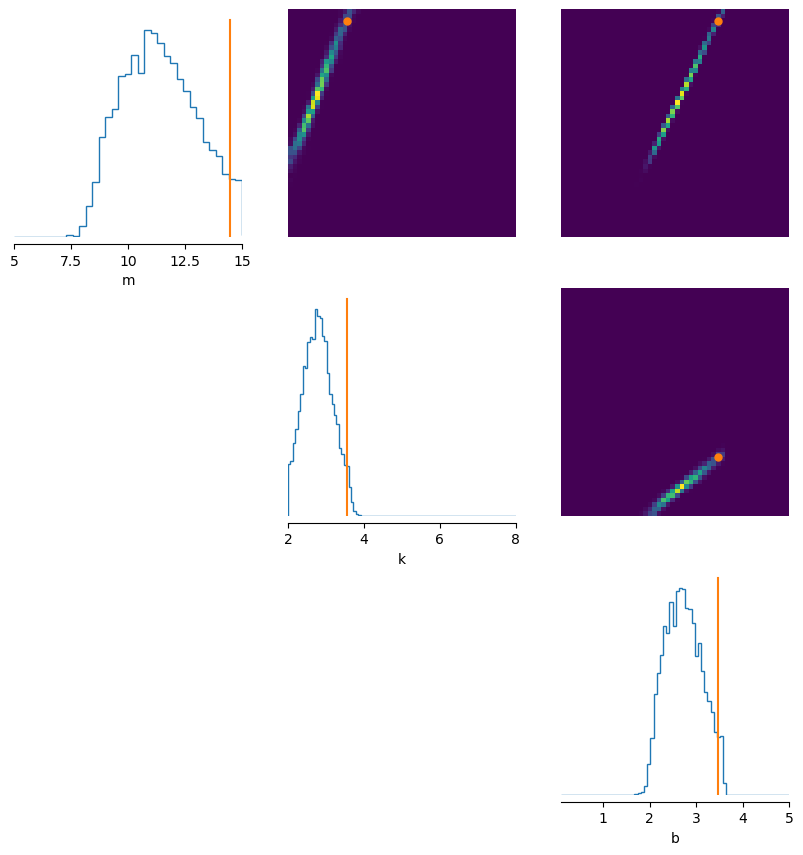

In [ ]:
test_theta = prior.sample((1,))
test_x = mass_spring_damper_fixed_simulator(test_theta.squeeze())
test_samples = posterior.sample((5000,), x=compute_summary_statistics(test_x))
fig, ax = analysis.pairplot(
    test_samples,
    points=test_theta,
    labels=["m", "k", "b"],
    limits=[[5, 15], [2.0, 8.0], [0.1, 5.0]]
)

In [ ]:
# Draw a sample from the posterior and convert to numpy for plotting.
posterior_sample = posterior.sample((1,), x=compute_summary_statistics(test_x)).numpy()
posterior_min = np.array([[9.5,   2,  0.5]])
posterior_max = np.array([[11.5,   4,  2.5]])
x_min = mass_spring_damper_fixed_simulator(posterior_min.squeeze())
x_max = mass_spring_damper_fixed_simulator(posterior_max.squeeze())
x_posterior = mass_spring_damper_fixed_simulator(posterior_sample.squeeze())
print(posterior_sample)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

[[11.987521   2.8981342  2.895092 ]]


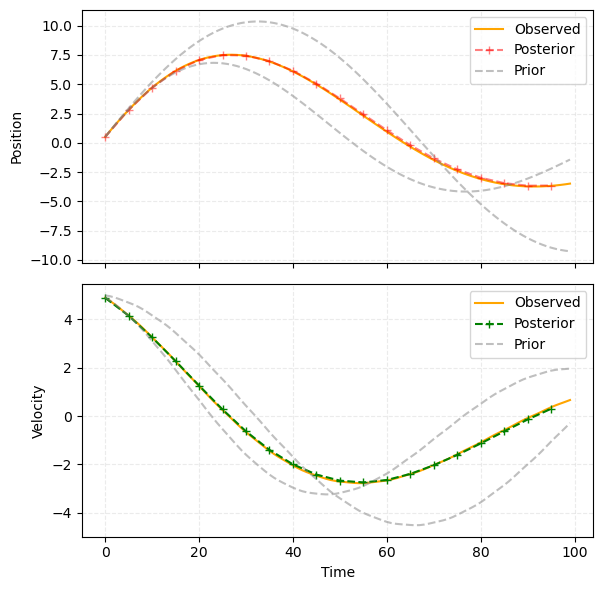

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
# Plot first column
axes[0].plot(t, test_x[:, 0], label="Observed",color="orange")
axes[0].plot(t[::5], x_posterior[::5, 0], '+', label="Posterior", linestyle='--' ,color="red", alpha=0.5)
axes[0].plot(t, x_min[:, 0], label="Prior", linestyle='--' ,color="grey", alpha=0.5)
axes[0].plot(t, x_max[:, 0], linestyle='--' ,color="grey", alpha=0.5)
axes[0].set_ylabel("Position")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.25)

# Plot second column
axes[1].plot(t, test_x[:, 1], label="Observed", color="orange")
axes[1].plot(t[::5], x_posterior[::5, 1], '+', label="Posterior", linestyle='--', color="green")
axes[1].plot(t, x_min[:, 1], label="Prior", linestyle='--', color="grey", alpha=0.5)
axes[1].plot(t, x_max[:, 1], linestyle='--', color="grey", alpha=0.5)
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Velocity")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.25)

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
theta_posterior = posterior.sample((100,), x=compute_summary_statistics(x_observed))

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
x_predictive = torch.stack([mass_spring_damper_fixed_simulator(theta) for theta in theta_posterior])

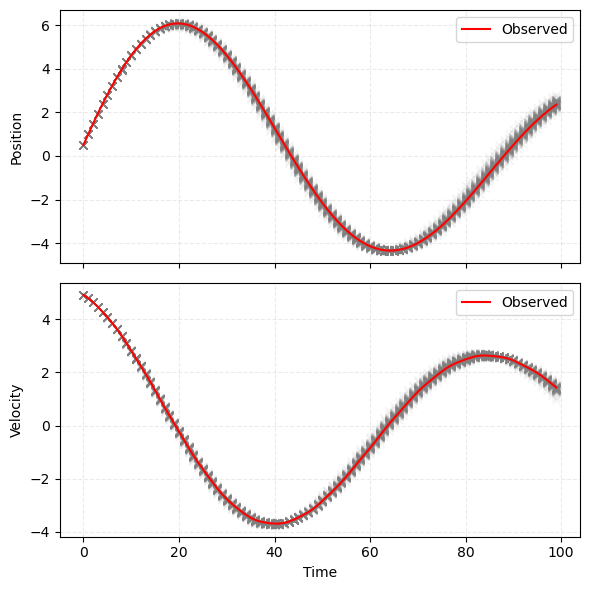

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

# Plot predictive trajectories in grey
for x_pred in x_predictive:
    axes[0].plot(t, x_pred[:, 0], 'x', color='grey', alpha=0.1)
    axes[1].plot(t, x_pred[:, 1], 'x', color='grey', alpha=0.1)

# Plot observed trajectory in red
axes[0].plot(t, x_observed[:, 0], label="Observed", color="red")
axes[0].set_ylabel("Position")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.25)

axes[1].plot(t, x_observed[:, 1], label="Observed", color="red")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Velocity")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.25)

# Show the plots
plt.tight_layout()
plt.show()